In [1]:
import traceback
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import os
import tempfile
import imageio as iio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('apikey.yml','r') as f:
    secret = yaml.safe_load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name=screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        if response.status_code == 200:
            with open(filepath,'wb') as f:
                f.write(response.content)
            image=iio.v3.imread(filepath)
            return image
        else:
            return None

In [4]:

# https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user
# API.get_user(*, user_id, screen_name, include_entities)

Caitlin Long 🔑⚡️🟠 CaitlinLong_ True Founder/CEO @CustodiaBank. #bitcoin since 2012. 22-yr Wall St veteran. Not advice; not views of Custodia Bank!
(48, 48, 3)


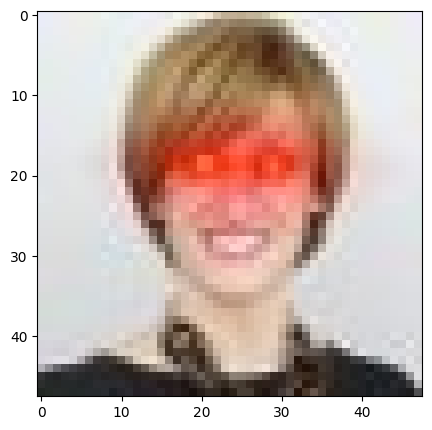

In [17]:
# @CaitlinLong_
screen_name = 'CaitlinLong_'
include_entities = True
user,profile_image = get_user_info(screen_name)

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

In [18]:
# https://docs.tweepy.org/en/stable/api.html?highlight=search_users#tweepy.API.search_users
# API.search_users(q, *, page, count, include_entities)
# 
# page – Specifies the page of results to retrieve. Note: there are pagination limits.
# count – The number of results to try and retrieve per page.

In [19]:
# set reference image and corresponding query using `user.name`

reference_screen_name = 'CaitlinLong_'
user,reference_image = get_user_info(screen_name)
query = user.name

print(query)

Caitlin Long 🔑⚡️🟠


In [20]:

# find  page_count*items_per_page count that matches the query
# API limit is 1k.
fetch = []
page_num = 10
count_per_page = 100

try:
    for x in range(page_num):
        print(f'querying page {x}')
        tmp = api.search_users(query,count=count_per_page,page=x)
        fetch.extend(tmp)
        if len(tmp)<count_per_page:
            break
except:
    traceback.print_exc()
    
print(len(fetch))

querying page 0
15


In [21]:
print(fetch[0])

User(_api=<tweepy.api.API object at 0x7f50b9542f70>, _json={'id': 717926102614716417, 'id_str': '717926102614716417', 'name': 'Caitlin Long 🔑⚡️🟠', 'screen_name': 'CaitlinLong_', 'location': 'Wyoming & #decentralized', 'description': 'Founder/CEO @CustodiaBank. #bitcoin since 2012. 22-yr Wall St veteran. Not advice; not views of Custodia Bank!', 'url': 'https://t.co/N0dnUhTbot', 'entities': {'url': {'urls': [{'url': 'https://t.co/N0dnUhTbot', 'expanded_url': 'http://www.caitlin-long.com', 'display_url': 'caitlin-long.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 182871, 'friends_count': 2322, 'listed_count': 3299, 'created_at': 'Thu Apr 07 04:04:56 +0000 2016', 'favourites_count': 26557, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 13592, 'lang': None, 'status': {'created_at': 'Sun Oct 30 16:50:01 +0000 2022', 'id': 1586762360198348800, 'id_str': '1586762360198348800', 'text': '@opekso

In [28]:

import time
# try to find a match based on profile image
mylist = []
profile_cache = {}
user_cache = {}
for n,x in enumerate(fetch):
    try:
        user,profile_image = get_user_info(x.screen_name)
        # skip item if its reference
        if user.screen_name == reference_screen_name:
            continue
        # if http error skip
        if profile_image is None:
            profile_cache[user.screen_name]=None
            continue
        # compute only if shape matches
        if profile_image.shape == reference_image.shape:
            item = dict(screen_name=user.screen_name,mean_diff=np.mean(profile_image-reference_image))
            profile_cache[user.screen_name]=profile_image.copy()
            user_cache[user.screen_name]=x
        else:
            item = dict(screen_name=user.screen_name,mean_diff=np.nan)
            profile_cache[user.screen_name]=None
            user_cache[user.screen_name]=x
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)
print(df.shape)

(14, 2)


In [29]:
df = df.sort_values('mean_diff')

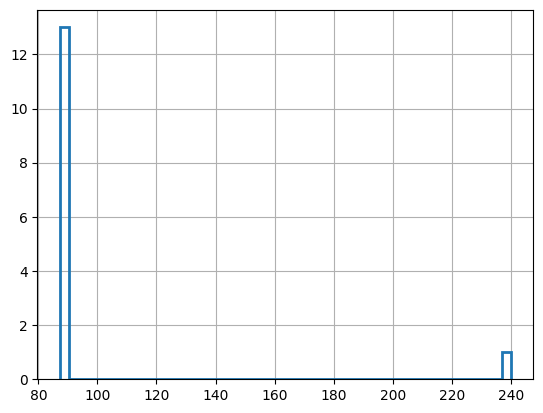

In [74]:
_=plt.hist(df.mean_diff,bins=50,histtype='step',linewidth=2)
plt.grid(True)

In [30]:
df

,screen_name,mean_diff
0,38ThoNguynThPh1,87.277633
1,JavierVilar9,87.277633
2,BandaraRivindu,87.277633
4,Ohoho671,87.277633
5,GCel45,87.277633
6,mainier75,87.277633
7,JoseMan86542712,87.277633
8,Tha60sPoint,87.277633
9,loud_caiozera,87.277633
10,Guilher59268414,87.277633


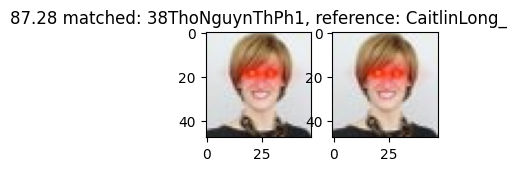

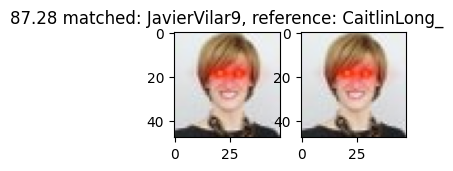

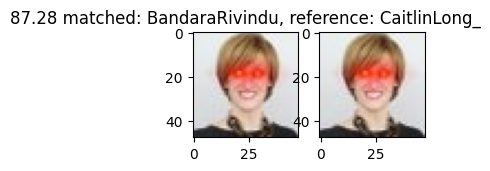

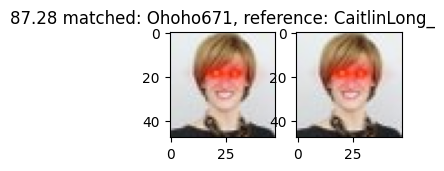

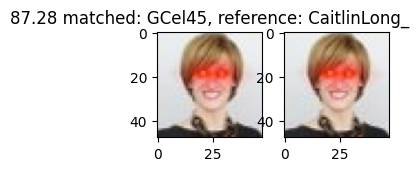

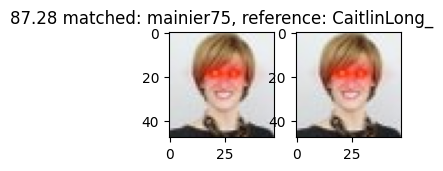

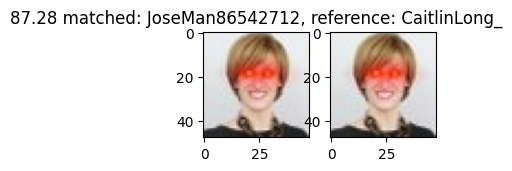

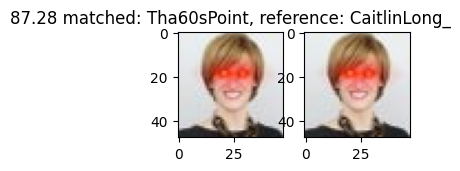

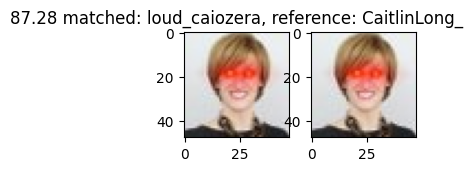

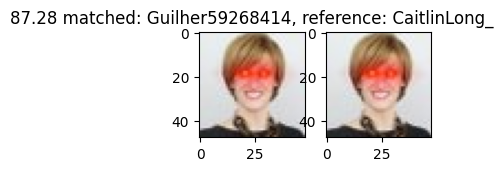

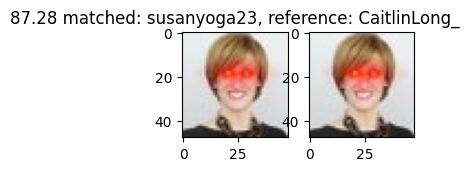

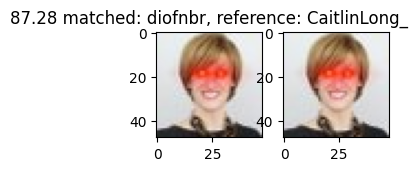

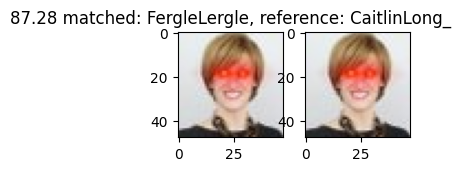

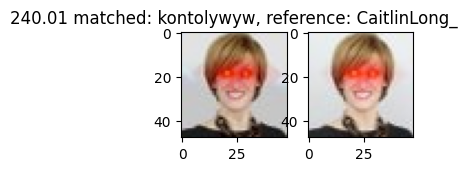

In [33]:
for n,row in df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'{row.mean_diff:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)

In [42]:
th = 250
likely_matched_df = df[df.mean_diff <= th].reset_index()
likely_matched_df

,index,screen_name,mean_diff
0,0,38ThoNguynThPh1,87.277633
1,1,JavierVilar9,87.277633
2,2,BandaraRivindu,87.277633
3,4,Ohoho671,87.277633
4,5,GCel45,87.277633
5,6,mainier75,87.277633
6,7,JoseMan86542712,87.277633
7,8,Tha60sPoint,87.277633
8,9,loud_caiozera,87.277633
9,10,Guilher59268414,87.277633


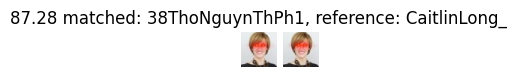

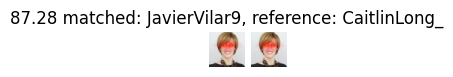

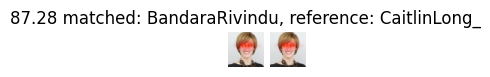

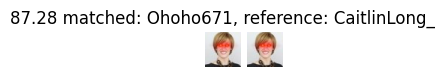

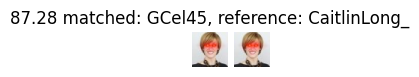

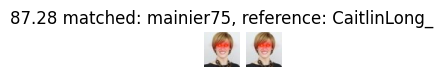

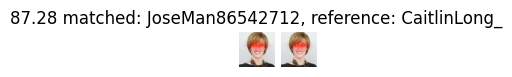

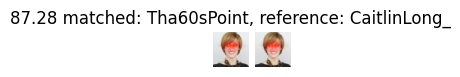

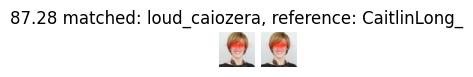

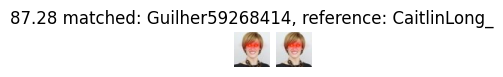

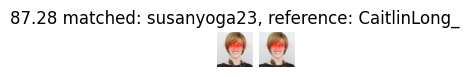

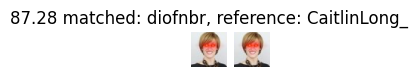

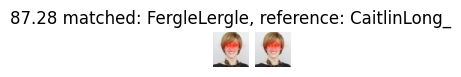

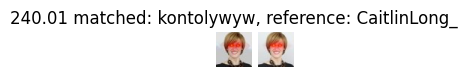

In [70]:
for n,row in likely_matched_df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(1,1))
    #plt.tight_layout()
    plt.subplot(121)
    plt.title(f'{row.mean_diff:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(reference_image)
    plt.axis('off')
    

In [72]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    print(f'screen_name: {user.screen_name}\t,mean_diff:{row.mean_diff:1.2f}, name:{user.name[:-5]}')
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

screen_name: 38ThoNguynThPh1	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/38ThoNguynThPh1
screen_name: JavierVilar9	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁܁܁܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/JavierVilar9
screen_name: BandaraRivindu	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/BandaraRivindu
screen_name: Ohoho671	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/Ohoho671
screen_name: GCel45	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/GCel45
screen_name: mainier75	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/mainier75
screen_name: JoseMan86542712	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁܁܁܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/JoseMan86542712
screen_name: Tha60sPoint	,mean_diff:87.28, name:Caitlin Long 🔑⚡️🟠܁ᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠᅠ
https://twitter.com/Tha60sPoint
scre

In [73]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

https://twitter.com/38ThoNguynThPh1
https://twitter.com/JavierVilar9
https://twitter.com/BandaraRivindu
https://twitter.com/Ohoho671
https://twitter.com/GCel45
https://twitter.com/mainier75
https://twitter.com/JoseMan86542712
https://twitter.com/Tha60sPoint
https://twitter.com/loud_caiozera
https://twitter.com/Guilher59268414
https://twitter.com/susanyoga23
https://twitter.com/diofnbr
https://twitter.com/FergleLergle
https://twitter.com/kontolywyw
